## 1. Подготовка данных

In [1]:
# Импорт необходимых для работы библиотек
import vk_api
import time
import functools
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

%matplotlib inline

In [317]:
# Общие настройки визуализации 
sns.set(
    rc = {
        "figure.figsize" :(14,7),
        "axes.titlesize" : 16,
        "axes.labelsize" : 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    },
    style = 'ticks',
    palette = 'deep'
)

## 2. Авторизация ВК API
Подключение происходило через Authorization Code Flow с получением токена для доступа к API *(в целях безопасности он был уже удален, несмотря на то, что здесь он представлен)*

In [5]:
token = 'vk1.a.jkaBE_lq0gr2zG1OKDzXiEVNnapzL34Lzd7TUe6kmsWOFcbCctVgag2YEKqyjdgiqtcURX7Wf64tDTGDwJ1j1R_yP4LHKqBYj15_AWrnoaZ-rPQf_ZTiGwUXwRGS9VojCjFCPCNmY045CZklBiWJPw9iabfvyrj32nRmns-Z779hYRzLlyxYgIRXN3bxmwgaIB85d8dr8Jmv9Z4ubpqHrw'

In [6]:
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

## 3. Получение и предобработка данных
Перед получением данных с помощью ВК API нужно написать вспомогательную функцию, которая будет рекурсивно отправлять запрос на получение данных с задержкой в 3 секунды. Это нужно для того, чтобы запросить сразу большой объем данных, так как для одного запроса существует ограничение в 1000 строк

In [7]:
def get_group_members(group_id: str, members: list, offset: int) -> list:
    '''
    Функция возвращает данные о пользователях определенного 
    сообщества 
    
    Параметры
    ----------
    group_id : string
        ID-сообщества, пользователей которых необходимо получить
    members: list
        список пользователей, которые нужно получить 
    offset: 
        сдвиг при повторном запросе к API
        
    Возвращаемое значение:
        объект с информацией о пользователях 
    '''
    if offset == 20000: return np.array(members).flatten().tolist()
    
    user_ids = vk.groups.getMembers(
        group_id = group_id,
        offset = offset,
        count = 1000 ,
        fields = [
            'sex',
            'bdate',
            'relation',
            'city',
            'home_town',
            'country',
            'university_name',
            'followers_count',
            'personal'
        ]
    )
    
    members.append((user_ids['items']))
    offset += 1000 
    time.sleep(3) # Запрос осуществляется каждые 3 секунды
        
    return get_group_members(group_id, members, offset)

In [13]:
# Фильтрация полученных данных
raw_members = list(filter(lambda x: x['is_closed'] == False, get_group_members('typical_yasnogorsk', [], 0)))

In [14]:
# Преобразование полученных данных в DataFrame
users_data = pd \
    .DataFrame(raw_members) \
    .drop(['can_access_closed','is_closed', 'deactivated', 'relation_partner'], axis=1) \
    .dropna()

users_data = users_data \
    .assign(
        current_city = users_data['city'].apply(lambda x: x['title']),
        current_country = users_data['country'].apply(lambda x: x['title'])) \
    .drop(['city', 'country'], axis=1) \
    .astype({'followers_count':'int64', 'relation':'int64'})

#### Данные были получены из сообщества "Типичный Ясногорск". Они представлены следующими столбцами:
- ID-пользователя (id)
- Год рождения (bdate)
- Пол (sex)
- Текущий город проживания (city)
- Родной город (home_town)
- Семейный статус (relation)
- Личная информация (personal)
- Страна (country)
- Количество подписчиков (followers_count)

Описание различных вариантов таких столбцов, как **relation, personal, sex** можно найти по [ссылке](https://dev.vk.com/ru/reference/objects/user)

## 4. Внешние признаки пользователей
Перед проведением какого-то описательного анализа выбранного сообщества, можно провести небольшой разведочный анализ данных, которые мы получили, чтобы увидеть из чего вообще состоят полученные данные

- Размер таблицы: строки - 2502, столбцы - 11
- Количество NULL-значений: отсутствуют
- Типы данных: ранговые (int64), номинальные (string), количественные - отсустсуют

In [22]:
# данные выглядят следующим образом
users_data.head(3)

id  followers_count  sex first_name     last_name      bdate  \
12  292904             6139    1     Полина  Александрова  29.8.1988   
14  298147             6371    1      Ирина       Иванова       30.5   
15  471527              466    1      Елена      Русакова       22.6   

   home_town  relation                                           personal  \
12                   1  {'langs': ['Русский'], 'langs_full': [{'id': 0...   
14      С-Пб         0  {'langs': ['Русский'], 'langs_full': [{'id': 0...   
15    Москва         1  {'inspired_by': '', 'langs': ['Русский'], 'lan...   

       current_city current_country  
12           Москва          Россия  
14  Санкт-Петербург          Россия  
15           Москва          Россия

### 4.1 Распределение пользователей сообщества "Типичный Ясногорск" по возрасту и гендеру

In [60]:
# Добавление столбца с возрастом
users_data['byear'] = users_data.bdate.apply(lambda x: x.split('.')[-1])
users_data['byear'] = np.where(users_data.byear.str.len() != 4, np.nan, users_data.byear)
users_data = users_data.dropna(subset='byear').astype({'byear':'int64'})
users_data = users_data.assign(age = datetime.date.today().year - users_data.byear)

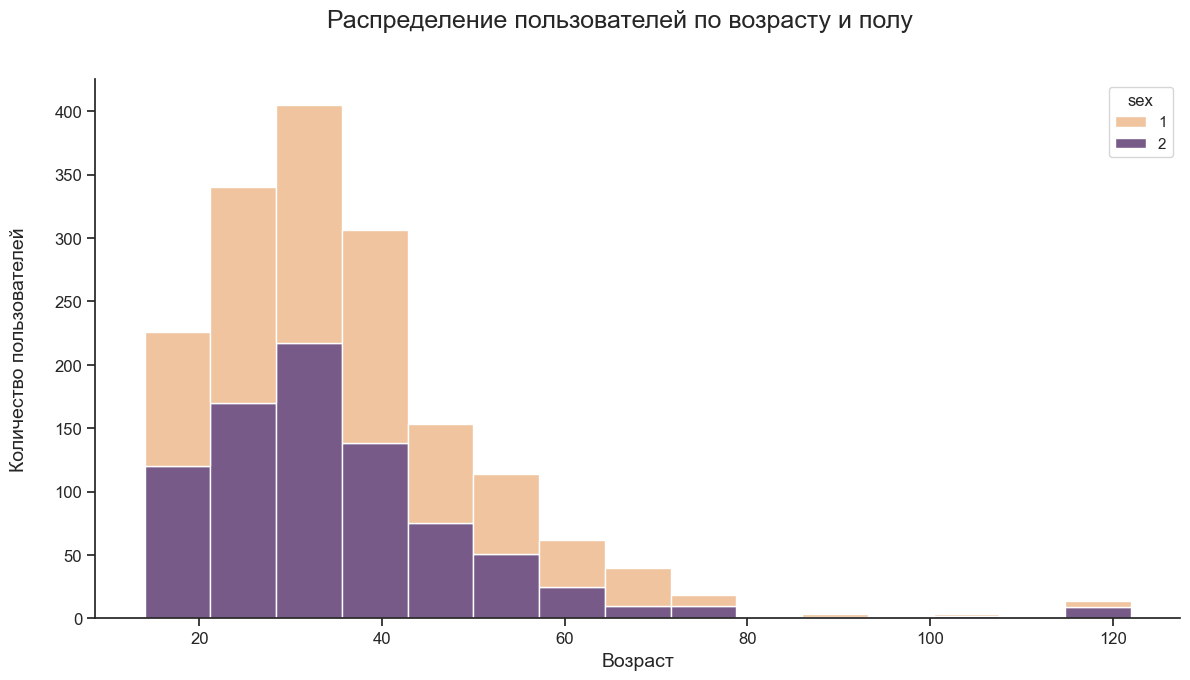

In [318]:
# Визуализация распределения по возрасту и гендеру
figure, ax1  = plt.subplots(nrows = 1, ncols = 1)

figure.suptitle(
    t        = 'Распределение пользователей по возрасту и полу',
    fontsize = 18
)

sns.histplot(
    data     = users_data,
    x        = 'age',
    ax       = ax1,
    stat     = 'count',
    bins     = 15,
    hue      = 'sex',
    palette  = 'flare',
    multiple = 'stack'
)

ax1.set(
    ylabel   = 'Количество пользователей\n',
    xlabel   = 'Возраст'
)

sns.despine()


# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/age_and_sex_hist',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 4.2 Распределение пользователей по возрастным категориям
Добавим столбец с возрастной категорией, чтобы наглядно можно было посмотреть, какие пользователи представлены в сообществе и затем визуализируем распределение пользователей для наглядности

In [238]:
# Добавление колонки с возрастной категорией 
users_data = users_data.assign(age_cat = pd.cut(
    users_data.age,
    bins = [0, 12, 18, 65, float('inf')],
    labels=['Дети', 'Подростки', 'Взрослые', 'Пожилые']))

In [273]:
users_by_age_cat = users_data.pivot_table(
    values  = 'id',
    index   = 'sex',
    columns = 'age_cat',
    aggfunc = 'count'
).reset_index()

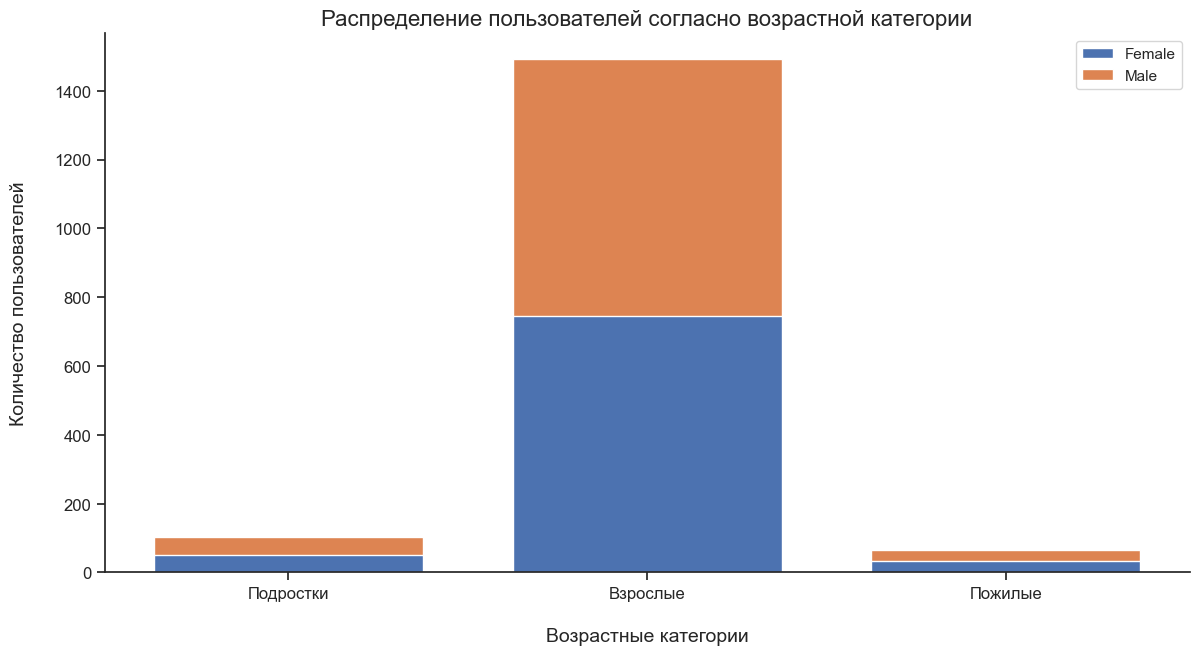

In [319]:
# Визуализация распределения по возрастной категории
figure, ax    = plt.subplots(nrows = 1, ncols = 1)

# Параметры распределения
bottom_line   = np.zeros(3)
age_cats      = ['Подростки', 'Взрослые', 'Пожилые']
shares        = {
    "Female" : users_by_age_cat.loc[users_by_age_cat.sex == 1][['Подростки', 'Взрослые', 'Пожилые']].values.flatten(),
    "Male"   : users_by_age_cat.loc[users_by_age_cat.sex == 2][['Подростки', 'Взрослые', 'Пожилые']].values.flatten(),
}

# Отрисовка распределения
for boolean, share in shares.items():
    p = ax.bar(
        x      = age_cats,
        height = share,
        width  = 0.75,
        label  = boolean,
        bottom = bottom_line
    )
    ax.set(
        ylabel   = 'Количество пользователей\n',
        xlabel   = '\nВозрастные категории',
    ) 
    bottom_line += weight_count

ax.set_title('Распределение пользователей согласно возрастной категории')
ax.legend(loc='upper right')

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/age',
#     format = 'png',
#     bbox_inches = 'tight'
# )

sns.despine()

# Здесь нужно не забыть про сохранение визуализации

### 4.3 Распределение пользователей по текущему городу проживания

In [285]:
users_by_current_city = users_data \
    .current_city \
    .value_counts() \
    .to_frame() \
    .head(10)

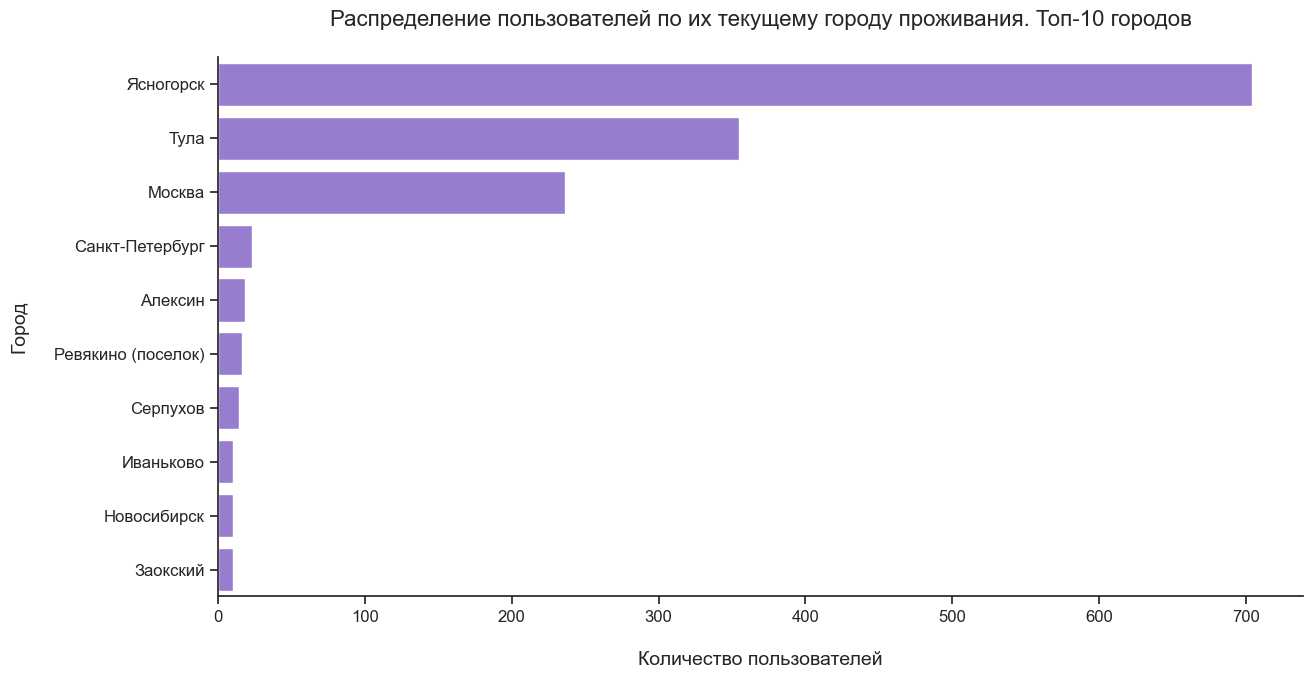

In [320]:
# Визуализация распределения по текущему городу проживания
figure, ax = plt.subplots(nrows = 1, ncols = 1)

sns.barplot(
    data  = users_by_current_city,
    x     = 'current_city',
    y     = users_by_current_city.index,
    ax    = ax,
    color = 'mediumpurple'
)

ax.set(
    title       = 'Распределение пользователей по их текущему городу проживания. Топ-10 городов\n',
    ylabel      = 'Город\n',
    xlabel      = '\nКоличество пользователей'
)

sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/city_distribution',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 4.4 Распределение пользователей по их семейному статусу
Перед тем, как начать анализировать данные, нужно поменять категориальную переменную со статусом с цифры на текстовое описание 

In [303]:
# Добавление колонки с текстовым описанием семейного статуса пользователя
bins = [i for i in range(-1, 9)]
users_data['relation_cat'] = pd.cut(
    users_data.relation,
    bins = bins,
    labels = [
        'Неизвестно',
        'Холост',
        'Есть партнер',
        'Помолвлен(а)',
        'Женат/Замужем',
        'Все сложно',
        'В активном поиске',
        'Влюблен(а)',
        'В гражданском браке'
    ]
)

In [309]:
users_by_relation = users_data \
    .relation_cat \
    .value_counts() \
    .to_frame() 

In [310]:
users_by_relation

relation_cat
Неизвестно                    788
Женат/Замужем                 502
Холост                        140
В активном поиске             119
Влюблен(а)                     61
Есть партнер                   28
Все сложно                     25
В гражданском браке            13
Помолвлен(а)                   11

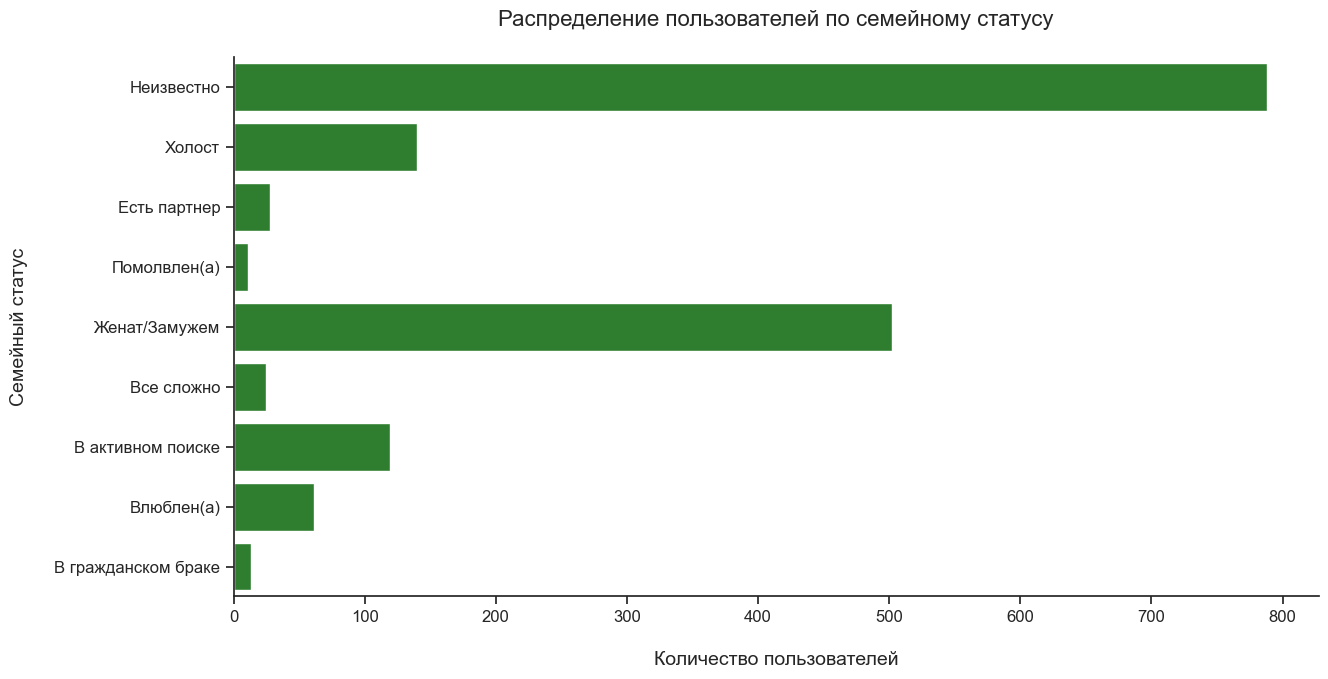

In [321]:
# Визуализация распределения пользователей по их семейному статусу
figure, ax = plt.subplots(nrows = 1, ncols = 1)

sns.barplot(
    data  = users_by_relation, 
    x     = 'relation_cat',
    y     = users_by_relation.index,
    ax    = ax,
    color = 'forestgreen'
)

ax.set(
    title  = 'Распределение пользователей по семейному статусу\n',
    ylabel = 'Семейный статус\n',
    xlabel = '\nКоличество пользователей'
)

sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/relation',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 4.5 Распределение пользователей по странам. Топ-5 стран

In [332]:
users_by_country = users_data \
    .current_country \
    .value_counts() \
    .to_frame() \
    .head(5)

users_by_country

current_country
Россия                1607
Украина                 37
США                     10
Беларусь                 3
Казахстан                3

##  5. Персональные навыки и привычки пользователей

In [333]:
users_data['has_personal_info'] = users_data.personal.apply(lambda x: type(x) == list)
users_data = users_data[users_data.has_personal_info == False]

In [334]:
def get_value(info: dict, key: str):
    '''
    Функция, которая возвращает значение из словаря, 
    если присутствует соответствующий ключ. В противном
    случае возвращается NaN
    
    Параметры
    ----------
    info : dict
        Словарь
    key: str
        Соответствующий ключ
        
    Возвращаемое значение: 
        Значение, соответствующее ключу, или NaN
    '''
    try:
        return info[key]
    except:
        return np.nan

Перед тем, как начать анализировать распределение пользователей на основе их персональных навыков, привычек и прочей информации, необходимо добавить новые столбцы, так как при запросе по ВК API, такая информация возвращается в качестве словарей

In [335]:
# Добавляем столбцы с персональной информацией
users_data = users_data \
    .assign(
        languages   = users_data.personal.apply(lambda x: get_value(x, 'langs')).fillna('Неизвестно'),
        religion    = users_data.personal.apply(lambda x: get_value(x, 'religion')).fillna('Неизвестно'),
        political   = users_data.personal.apply(lambda x: get_value(x, 'political')).fillna('Неизвестно'),
        people_main = users_data.personal.apply(lambda x: get_value(x, 'people_main')).fillna('Неизвестно'),
        life_main   = users_data.personal.apply(lambda x: get_value(x, 'life_main')).fillna('Неизвестно'),
        smoking     = users_data.personal.apply(lambda x: get_value(x, 'smoking')).fillna('Неизвестно'),
        alcohol     = users_data.personal.apply(lambda x: get_value(x, 'alcohol')).fillna('Неизвестно')
    ) \
    .explode('languages') \
    .drop('personal', axis=1)

### 5.1 Распределение пользователей по их отношению к курению и алкоголю

In [341]:
# Распределение пользователей по их отношению к курению
users_by_smoking = users_data \
    .loc[~users_data.smoking.isin(['Неизвестно', 0])] \
    .groupby('smoking', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'smoking':{
        1:'Строго негативное',
        2:'Негативное',
        3:'Компромисс',
        4:'Нейтральное',
        5:'Положительное'
    }}) \
    .sort_values('users_count', ascending=False)

In [371]:
# Распределение пользователей по их отношению к алкоголю
users_by_alcohol = users_data \
    .loc[~users_data.alcohol.isin(['Неизвестно', 0])] \
    .groupby('alcohol', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'alcohol': {
        1:'Строго негативное',
        2:'Негативное',
        3:'Компромисс',
        4:'Нейтральное',
        5:'Положительное'
    }}) \
    .sort_values('users_count', ascending=False)

In [372]:
smoking_names = users_by_smoking.smoking.to_list()
smoking_user_count = users_by_smoking.users_count.to_list()
alcohol_names = users_by_alcohol.alcohol.to_list()
alcohol_user_count = users_by_alcohol.users_count.to_list()

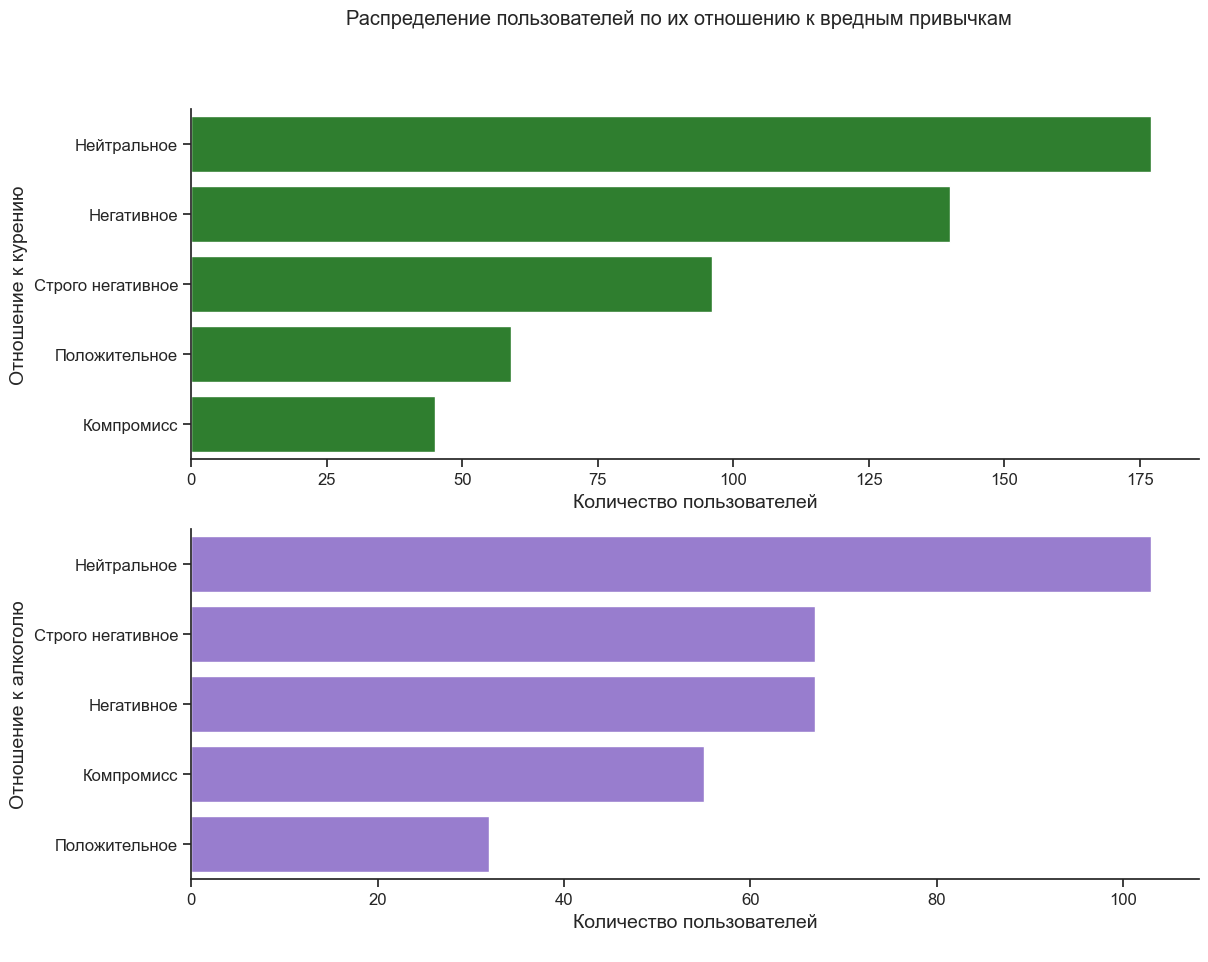

In [429]:
# Визуализация распределения пользователей по их отношению к алгоколю и курению
figure, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 10))
colors       = ['forestgreen', 'mediumpurple']
samples      = [users_by_smoking, users_by_alcohol]
labels       = ['smoking', 'alcohol']
titles       = ['Отношение к курению', 'Отношение к алкоголю']

for ax, color, sample, label, title in zip(axes.flatten(), colors, samples, labels, titles):
    sns.barplot(
        data  = sample,
        y     = sample[label],
        x     = sample.users_count,
        ax    = ax,
        color = color
    )
    ax.set(
        xlabel = 'Количество пользователей\n',
        ylabel = '{}'.format(title)
    )
    
figure.suptitle('Распределение пользователей по их отношению к вредным привычкам')
sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/smoking_and_alco',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 5.2 Распределение пользователей по их политическим взглядам

In [376]:
users_by_politic = users_data \
    .loc[~users_data.political.isin(['Неизвестно', 0])] \
    .groupby('political', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'political': {
        1:'Коммунизм',
        2:'Социализм',
        3:'Умеренный',
        4:'Либерализм',
        5:'Консерватизм',
        6:'Монархизм',
        7:'Ультраконсерватизм',
        8:'Нейтральный',
        9:'Либертарианизм'
    }}) \
    .sort_values('users_count', ascending = False)

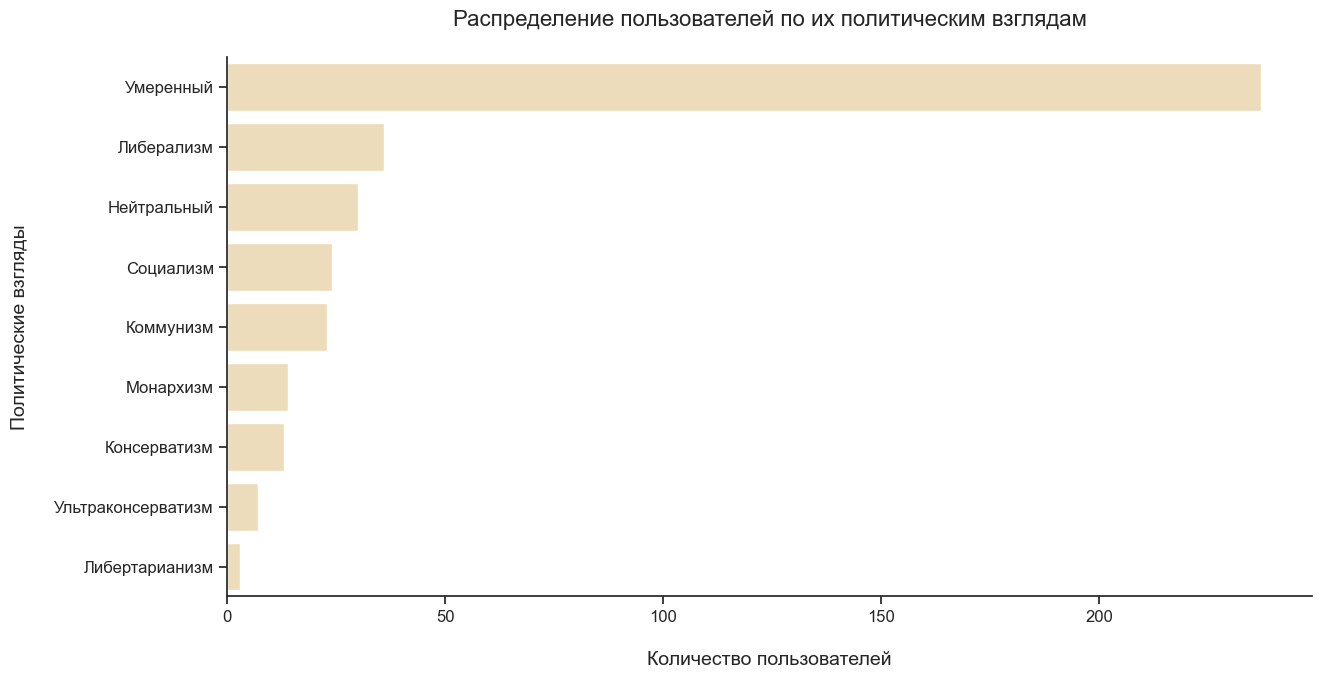

In [386]:
# Визуализация распределения пользователей по их политическим взглядам
figure, ax = plt.subplots(nrows = 1, ncols = 1)

sns.barplot(
    data  = users_by_politic,
    x     = 'users_count',
    y     = 'political',
    ax    = ax,
    color = 'wheat'
)

ax.set(
    title       = 'Распределение пользователей по их политическим взглядам\n',
    ylabel      = 'Политические взгляды\n',
    xlabel      = '\nКоличество пользователей'
)

sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/political_views',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 5.3 Распределение пользователей по их жизненным ценностям

In [394]:
users_by_people_main = users_data \
    .loc[~users_data.people_main.isin(['Неизвестно', 0])] \
    .groupby('people_main', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'people_main':{
        1:'Ум и образование', 
        2:'Честность и доброта',
        3:'Красота и здоровье',
        4:'Власть и богатство',
        5:'Смелость и упорство',
        6:'Чувство юмора и жизнелюбие'
    }}) \
    .sort_values('users_count', ascending = False)

In [392]:
users_by_life_main = users_data \
    .loc[~users_data.life_main.isin(['Неизвестно', 0])] \
    .groupby('life_main', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .replace({'life_main':{
        1:'Семья и дети',
        2:'Карьера и деньги',
        3:'Развлечения и отдых',
        4:'Наука и знания',
        5:'Совершенствование мира',
        6:'Саморазвитие',
        7:'Красота и искусство',
        8:'Слава и влияние'
    }}) \
    .sort_values('users_count', ascending = False)

In [395]:
life_main_labels = users_by_life_main.life_main.to_list()
life_main_sizes = users_by_life_main.users_count.to_list()
people_main_labels = users_by_people_main.people_main.to_list()
people_main_sizes = users_by_people_main.users_count.to_list()

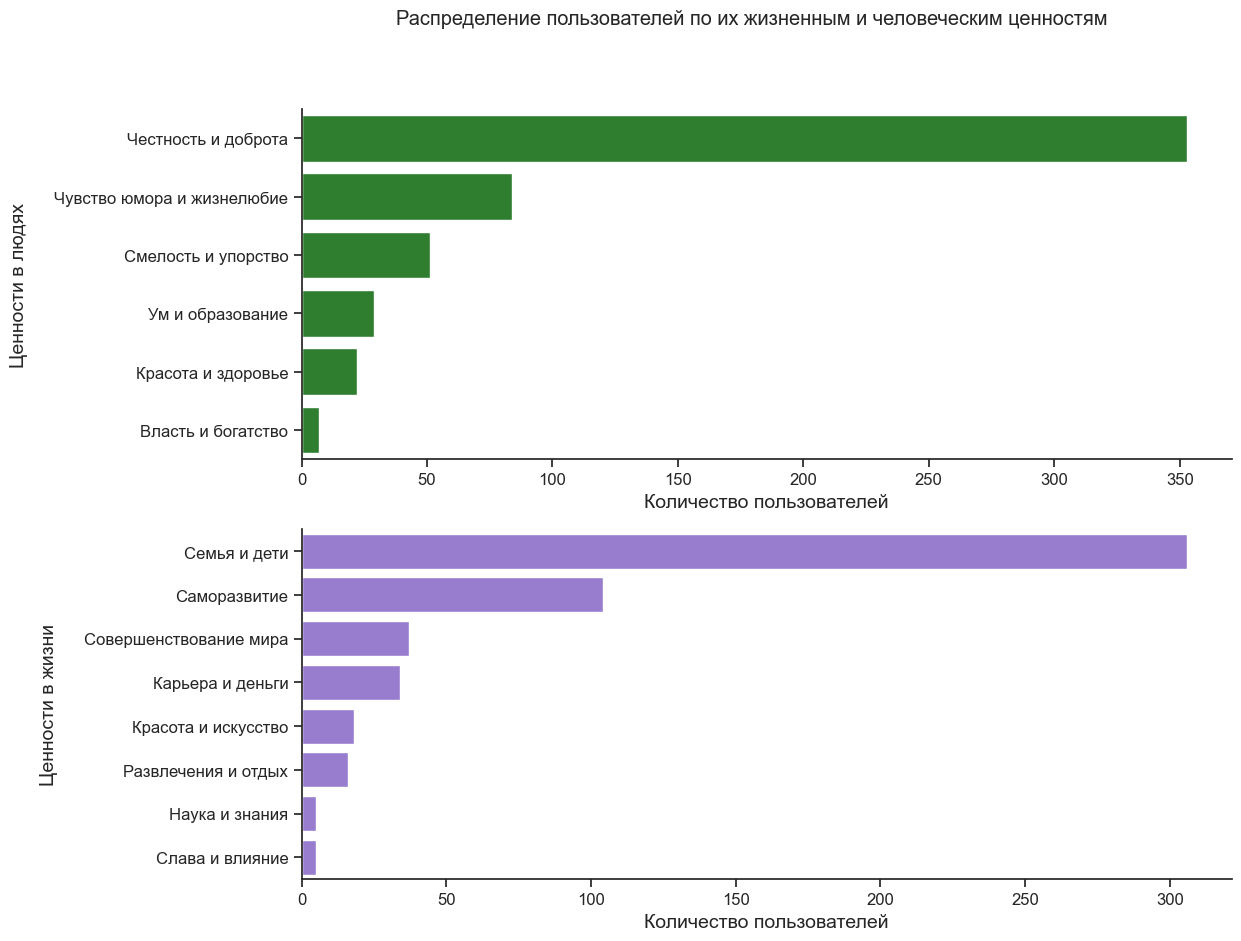

In [430]:
# Визуализация распределения пользователей по их жизненным ценностям
figure, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))
colors             = ['forestgreen', 'mediumpurple']
samples            = [users_by_people_main, users_by_life_main]
labels             = ['people_main', 'life_main']
titles             = ['Ценности в людях', 'Ценности в жизни']

for ax, color, sample, label, title in zip(axes.flatten(), colors, samples, labels, titles):
    sns.barplot(
        data  = sample,
        y     = sample[label],
        x     = sample.users_count,
        ax    = ax,
        color = color
    )
    ax.set(
        xlabel = 'Количество пользователей',
        ylabel = '{}\n'.format(title)
    )
    
figure.suptitle('Распределение пользователей по их жизненным и человеческим ценностям')
sns.despine()

# plt.savefig(
#     fname = '/Users/aleksejpopov/Desktop/Y_Analysis/plots/life_people_values',
#     format = 'png',
#     bbox_inches = 'tight'
# )

### 5.4 Users Distribution By Languages

In [34]:
# Users Distribution By Languages
users_by_language = users_data \
    .groupby('languages', as_index=False) \
    .agg({'id':'count'}) \
    .rename(columns={'id':'users_count'}) \
    .sort_values('users_count', ascending=False) \

# Distinct Top-5 Languages 
top_languages = users_by_language.loc[users_by_language.languages != 'unknown'].head(5)

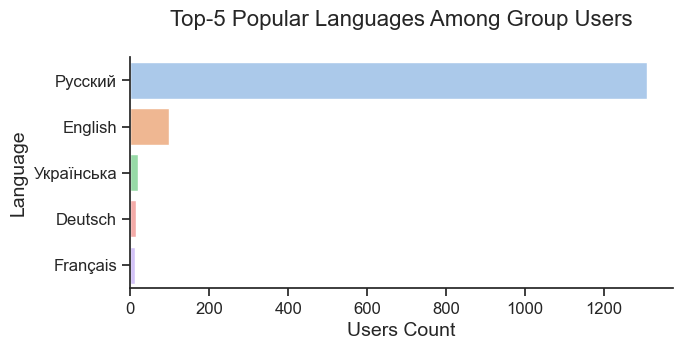

In [35]:
# Distribution Visualisation
top_languages_dist = sns.barplot(x='users_count', y='languages', data=top_languages, palette='pastel')
top_languages_dist.set(
    title = 'Top-5 Popular Languages Among Group Users\n',
    ylabel = 'Language',
    xlabel = 'Users Count'
)

sns.despine()

# Saving Distribution
plt.savefig(
    fname='/Users/aleksejpopov/Desktop/Y_Analysis/plots/popular_languages',
    format = 'png',
    bbox_inches = 'tight'
)

## 6. Final Table Styling

In [36]:
# Set Styles
cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#FFFFE0")]
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: darkgrey; font-weight:normal;"
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #800000; color: white;"
}

users_data.style.set_table_styles([cell_hover, index_names, headers])

In [1286]:
# Saving Final Table
users_data.to_csv(
    path_or_buf = '/Users/aleksejpopov/Desktop/Y_Analysis/followers_data.csv',
    sep = ',',
    index = False
    )

## Appendix A: Interactive Charts

### Followers Distribution By Sex

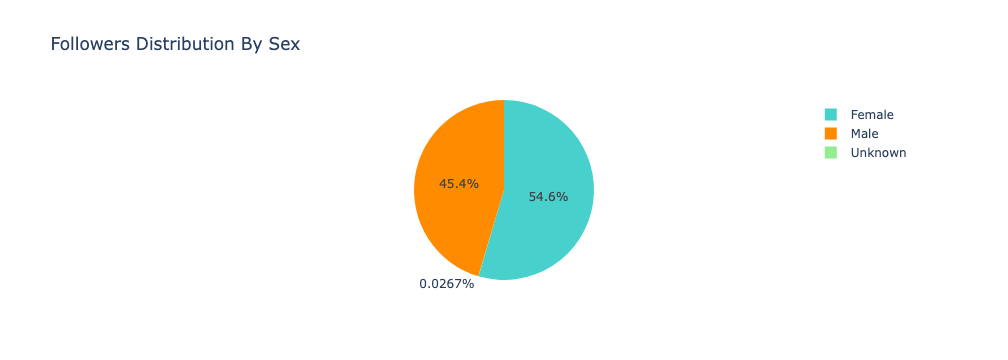

In [75]:
# Creating Interactive Plot
users_by_sex_idist = px.pie(
    users_by_sex,
    values = 'users_count',
    names = 'sex',
    title = 'Followers Distribution By Sex',
    color_discrete_sequence = ['mediumturquoise', 'darkorange', 'lightgreen']
)
users_by_sex_idist.show()

# Saving Interactive Plot
users_by_sex_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/sex_dist.html')

### Followers Distribution By Sex and Age

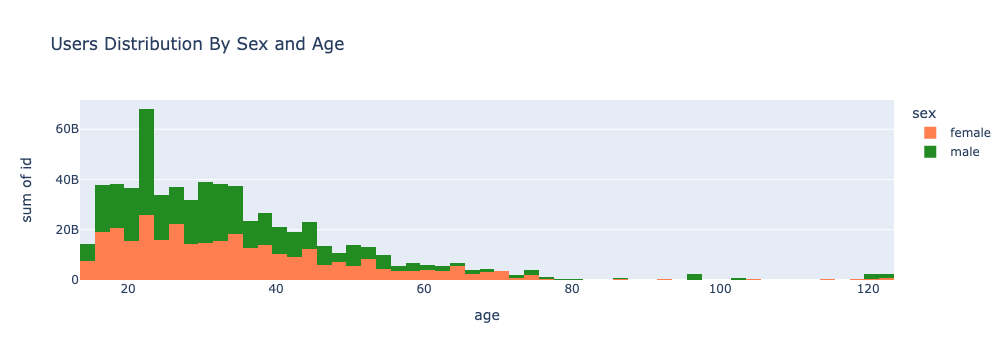

In [76]:
# Creating Interactive Plot
users_data = users_data.replace({'sex':{0:'unknown', 1:'female', 2:'male'}})
users_by_sex_age_idist = px.histogram(
    users_data,
    x = 'age',
    y = 'id',
    color = 'sex',
    color_discrete_sequence = ['coral', 'forestgreen'],
    title = 'Users Distribution By Sex and Age'
)
users_by_sex_age_idist.show()

# Saving Interactive Plot
users_by_sex_age_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/sex_age_dist.html')

### Followers Distribution By Age Categories

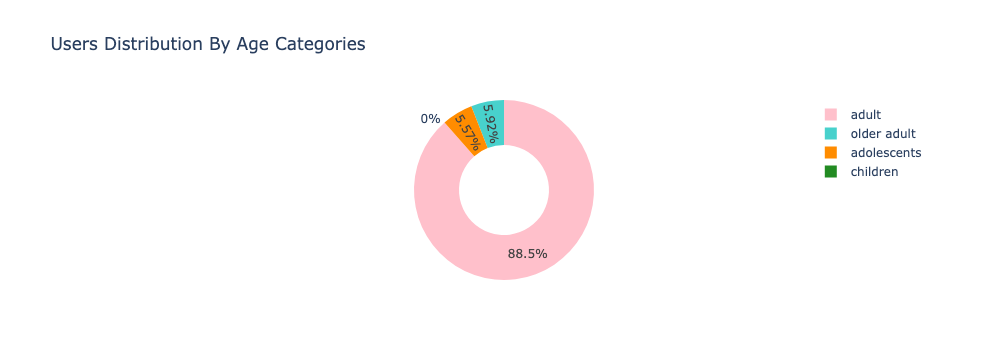

In [77]:
# Creating Interactive Plot
users_by_age_cat_idist = px.pie(
    users_by_age,
    values = 'users_count',
    names = 'age_cat',
    title = 'Users Distribution By Age Categories',
    color_discrete_sequence = ['pink', 'mediumturquoise', 'darkorange', 'forestgreen'],
    hole = 0.5
    
)
users_by_age_cat_idist.show()
# Saving Interactive Plot 
users_by_age_cat_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/age_cat_dist.html')

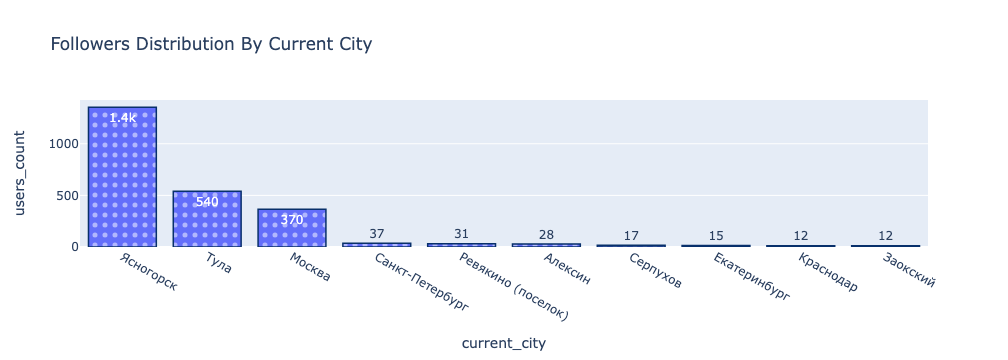

In [78]:
# Creating Interactive Plot
top_users_by_ht = top_users_by_ht.head(10)
top_users_by_ht_idist = px.bar(
    top_users_by_ht,
    x = 'current_city',
    y = 'users_count',
    title = 'Followers Distribution By Current City',
    text_auto='.2s',
    pattern_shape_sequence = ['.']
)
top_users_by_ht_idist.update_traces(
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5
)
top_users_by_ht_idist.show()

# Saving Interactive Plot
top_users_by_ht_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/city_dist.html')

### Followers Distribution By Relation

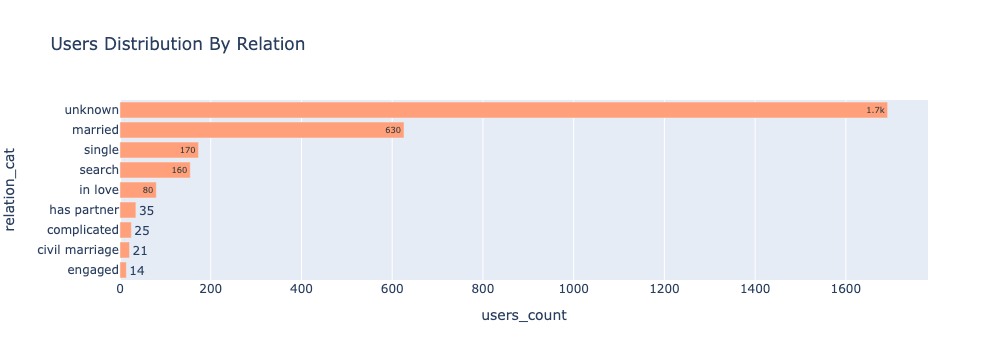

In [79]:
# Creating Interactive Plot
users_by_relation_idist = px.bar(
    users_by_relation.sort_values('users_count'),
    x = 'users_count',
    y = 'relation_cat',
    title = 'Users Distribution By Relation',
    text_auto = '.2s',
    color_discrete_sequence = ['lightsalmon']
)
users_by_relation_idist.show()

#Saving Interactive Plot
users_by_relation_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/rel_dist.html')

### Followers Distribution By Harmful Habits

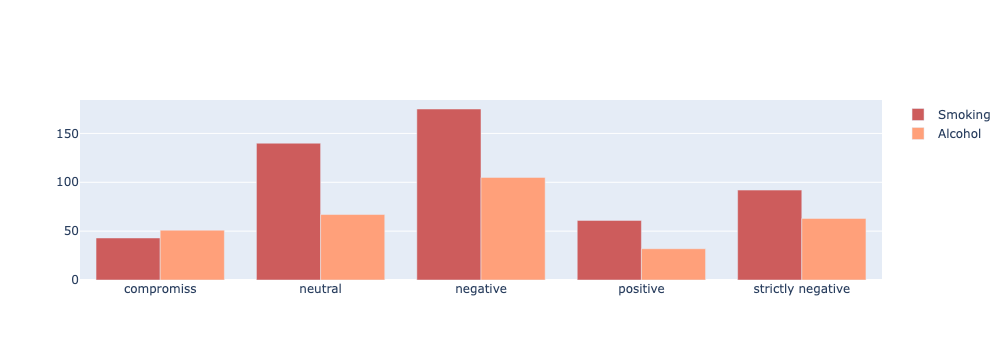

In [80]:
# Creating Interactive Plot
attitude = ['compromiss', 'neutral', 'negative', 'positive', 'strictly negative']

figure = go.Figure()
figure.add_trace(go.Bar(
    x = attitude,
    y = users_by_smoking.users_count.to_list(),
    name = 'Smoking',
    marker_color = 'indianred'
))
figure.add_trace(go.Bar(
    x = attitude,
    y = users_by_alcohol.users_count.to_list(),
    name = 'Alcohol',
    marker_color = 'lightsalmon'
))
figure.show()

# Saving Interactive Plot
figure.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/habits_dist.html')

### Followers Distribution By Political Views

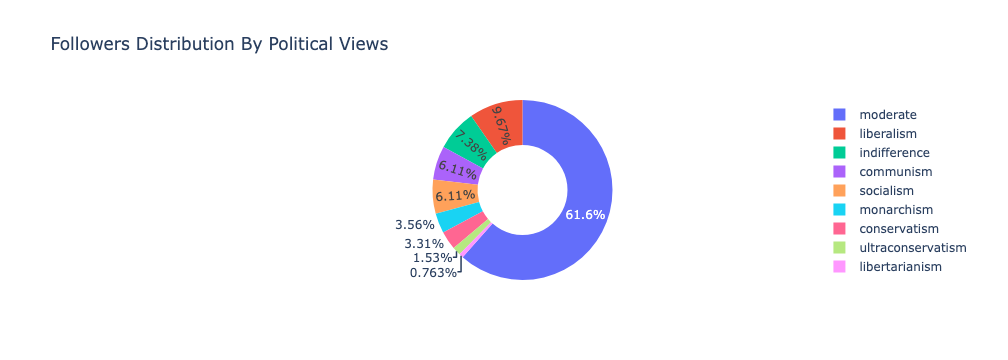

In [82]:
# Creating Interactive Plot
users_by_politic_idist = px.pie(
    users_by_politic,
    values = 'users_count',
    names = 'political',
    title = 'Followers Distribution By Political Views',
    hole = 0.5
    
)
users_by_politic_idist.show()

# Saving Interactive Plot
users_by_politic_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/politics_dist.html')

### Followers Distribution By People Values

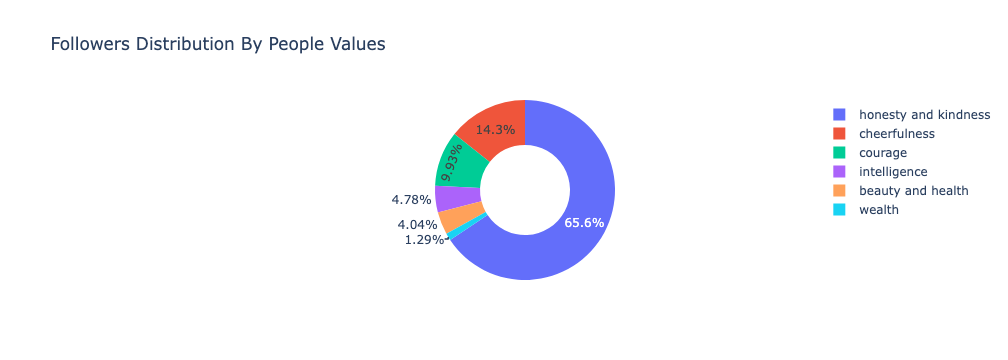

In [83]:
# Creating Interactive Plot
users_by_people_main_idist = px.pie(
    users_by_people_main,
    values = 'users_count',
    names = 'people_main',
    title = 'Followers Distribution By People Values',
    hole = .5
)
users_by_people_main_idist.show()

# Saving Interactive Plot
users_by_people_main_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/people_values_dist.html')

### Followers Distribution By Life Values

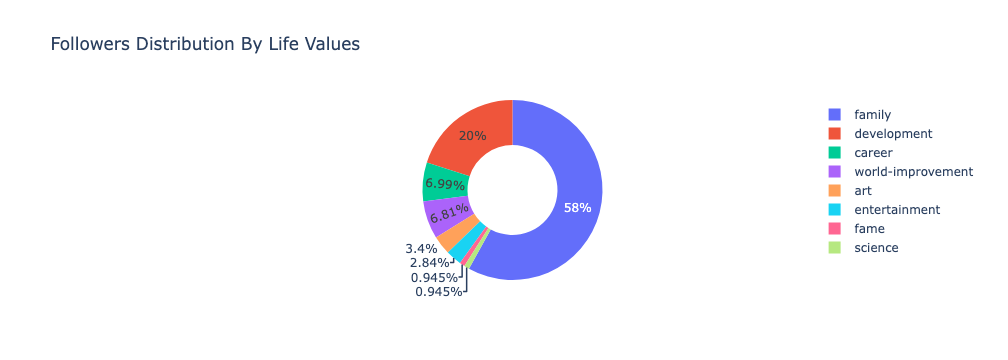

In [84]:
# Creating Interactive Plot
users_by_life_main_idist = px.pie(
    users_by_life_main,
    values = 'users_count',
    names = 'life_main',
    title = 'Followers Distribution By Life Values',
    hole = .5
)
users_by_life_main_idist.show()

# Saving Interactive Plot
users_by_life_main_idist.write_html('/Users/aleksejpopov/Desktop/Y_Analysis/typical_yasn_superficial_analysis/iplots/life_values_dist.html')